<h2> Models to Classify Cancer Cells whether the samples are benign or malignant.</h2>

In this notebook, you will use SVM (Support Vector Machines) to build and train a model using
human cell records, and classify cells to whether the samples are benign or malignant.

<b> import libaries</b>

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

<b> Load the Cancer data</b> 

In [2]:
#Click here and press Shift+Enter
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

--2020-12-07 07:11:04--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0.07s   

2020-12-07 07:11:04 (272 KB/s) - ‘cell_samples.csv’ saved [20675/20675]



<h2> Load Data From CSV File</h2> 

In [3]:
import pandas as pd
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
cell_df.tail()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4
698,897471,4,8,8,5,4,5,10,4,1,4


The ID field contains the patient identifiers. The characteristics of the cell samples from each
patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the
closest to benign.
The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether
the samples are benign (value = 2) or malignant (value = 4).
Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

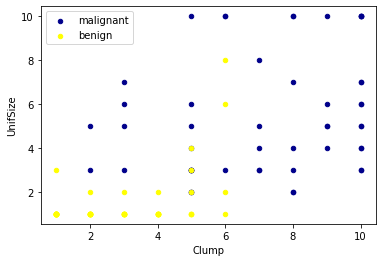

In [5]:
import matplotlib.pyplot as plt
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

<h2> Data pre-processing and selection</h2>

Lets first look at columns data types:

In [6]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the BareNuc column includes some values that are not numerical. We can drop those
rows:

In [7]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [8]:
import numpy as np
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh','SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this
field can have one of only two possible values, we need to change its measurement level to reflect
this.

In [9]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

<h2> 2.0 Train/Test dataset</h2>

Okay, we split our dataset into train and test set:

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,random_state=4)
print ('Train set:', X_train.shape, y_train.shape)
print ('Test set:', X_test.shape, y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2> 2.1  Modeling (SVM with Scikit-learn)</h2>

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically,
mapping data into a higher dimensional space is called kernelling. The mathematical function used
for the transformation is known as the kernel function, and can be of different types, such as:
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there’s
no easy way of knowing which function performs best with any given dataset, we usually choose
different functions in turn and compare the results. Let’s just use the default, RBF (Radial Basis
Function) for this lab.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,random_state=4)
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

<b> After being fitted, the model can then be used to predict new values:</b>

In [14]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

<h2> Evaluation</h2>

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [16]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


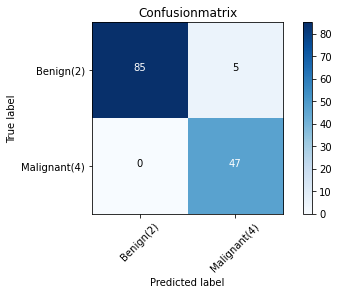

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False, title='Confusionmatrix')

<b> You can also easily use the f1_score from sklearn library:</b>

In [18]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.9639038982104676

<b> Lets try jaccard index for accuracy:</b> 